In [1]:
include("TidalLoveNumbersPorousK23fast.jl")
using .TidalLoveNumbers
using DoubleFloats
using PyPlot
using Statistics
using PyCall
using BenchmarkTools
    
@pyimport seaborn as sns
@pyimport matplotlib as mpl
@pyimport matplotlib.gridspec as gspec
#
PyPlot.isjulia_display[] = false;

PyPlot.matplotlib[:rc]("font",family="Arial", weight="medium", style="normal", size=12)
PyPlot.matplotlib[:rc]("axes",titlesize=14.5, labelsize=12, unicode_minus=false)
PyPlot.matplotlib[:rc]("xtick",labelsize=11.5)
PyPlot.matplotlib[:rc]("ytick",labelsize=11.5)
PyPlot.matplotlib[:rc]("pdf",fonttype=42)
PyPlot.matplotlib[:rc]("mathtext", fontset = "stix")

mpl.style.use("dark_background")

prec = TidalLoveNumbers.prec
precc = TidalLoveNumbers.precc

Complex{Double64}

In [2]:
non_dim = false

G = prec(6.6743e-11)
e = 0.0041

h_core = 700.0 - 690.0
h_mantle_low = 800. + 690
h_mantle_up = 300. - 0.

h_crust = 20.
ω0 = 2*2.047e-5
ω = ω0

#enceladus test model:
n = 2
ρₛ = [3300, 3300, 3300, prec(3300)]
r = [0, 
     h_core, 
     h_core+h_mantle_low, 
     h_core+h_mantle_low+h_mantle_up, 
     h_core+h_mantle_low+h_mantle_up+h_crust] .* 1e3
μ = [60+0im, 60, 60, prec(60)] .* 1e9
κ = [100e9, 100e9, 100e9, 100e9] .* 100000.0
η = [1e25, 1e25, 1e25, 1e25]

R = r[end]
μ0 = μ[end]
bp = 3
tp = 3


ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 100e9, 0] .* 100000.0
κd = 0.05κ
k = [0, 0, 1e-7, 0]

ηₗ = [0, 0, 1.0, 0]
ϕ =  [0, 0, prec(0.1), 0]

ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
# ρ = ρₛ
r = expand_layers(r)
g = get_g(r, ρ)

 
ρ0 = ρ[end]
μ0 = ρ0*g[end,end]*R

Gnd = G*ρ0^2*R^2/μ0;



# Now non-dimensionalise?
T = 2π/ω0

if non_dim
    r = r./R
    ρₛ = ρₛ ./ ρ0
    ρ = ρ ./ ρ0
    μ = μ ./ μ0
    κ = κ ./ μ0
    η = η ./ (μ0 * 2π/ω0 )

    ρₗ = ρₗ ./ ρ0
    κₗ = κₗ ./ μ0
    k = k ./ R^2

    ηₗ = ηₗ ./ (μ0 * 2π/ω0 )


    ω = 2π

    set_G(Gnd)
    g = get_g(r, ρ)

end



In [3]:
res = 10.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res);

# Total Heating

In [4]:
ηs = 8:0.5:22

res = 10.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res)

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
# println(size(axes))

colors = ["C1", "C2", "C3", "C4"]
cmap = PyPlot.cm.cool
colors = [0.2, 0.4, 0.6, 0.8]
cnt = 1
for j in -6:1:-6
    Edot = zeros(length(ηs))
    Edots = zeros(length(ηs))
    k_ln = zeros(ComplexF64, length(ηs))
    k_lns = zeros(ComplexF64, length(ηs))
    for i in eachindex(ηs)
        #######################################################################
        η[3] = 10.0^ηs[i] * (non_dim ? 1.0/(μ0*T) : 1.0)

        # k = 10^-j * eta_l 
        k[3] = 10.0^j * (non_dim ? 1.0/R^2 : 1.0)

        μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

        # μc = μ

        y = ComplexF64.(calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ,κd, ηₗ, ϕ, k))
        y2 = ComplexF64.(calculate_y(r, ρ, g, μc, κ))

        # display(y)

        yR = y[:,end,end]
        yR2 = y2[:,end,end]

        k2 = yR[5] - 1
        k22 = yR2[5] - 1

        k_ln[i] = k2
        k_lns[i] = k22
    
        # println(k2)

        # k2_2[i] = k2    # println("Porous body k2 = ", k2)  
        # println("k2 = ", yR[5] - 1)  
        # println("h2 = ", -g[end]*yR[1] )
        Edot[i] = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
        Edots[i] = 21/2 * -imag(k22) * (ω0*R)^5/G * e^2
        # println("Dissipated Energy Total: ", Ediss2/1e9)

       

    end

    axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_ln), label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_lns), "w--")

    axes[2].loglog(10.0 .^ collect(ηs), Edot/1e12, label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    
    if j == -4 
        axes[2].loglog(10.0 .^ collect(ηs), Edots/1e12, "w--", label="no melt")
    else
        axes[2].loglog(10.0 .^ collect(ηs), Edots/1e12, "w--")
    end

    cnt += 1
end

axes[2].legend(frameon=false)

axes[1].set_ylabel("Tidal Love Number \$|k_2|\$")
axes[2].set_ylabel("Dissipated Power [TW]")
axes[1].set_xlabel("Asthenosphere Viscosity [Pa s]")
axes[2].set_xlabel("Asthenosphere Viscosity [Pa s]")

axes[2].axhspan((9.33-1.87)*1e13/1e12, (9.33+1.87)*1e13/1e12, alpha=0.8)
axes[1].set_ylim([0,1.3])
# fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)



MethodError: MethodError: no method matching calculate_y(::Matrix{Double64}, ::Vector{Double64}, ::Matrix{Double64}, ::Vector{Complex{Double64}}, ::Vector{Float64}, ::Float64, ::Vector{Int64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Double64}, ::Vector{Float64})

Closest candidates are:
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:976
  ...


# Porosity  

# Test 1 - Uniform solid body heating

In [5]:
# fig, ax = plt.subplots()


ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 100000000000000e9, 0]
κₛ = [0, 0, 100000000000000e9, 0]
k = [0, 0, 1e-6, 0]

ηₗ = [0, 0, 1e0, 0]

# η[3] = 1e14

ϕs = 0.1:0.1:0.1

ρₛ = [3300, 3300]
r = [0, 
     10, 
     1820] .* 1e3
μ = [60+0im, prec(60)] .* 1e9
κ = [100e9, 100e9] 
η = [1e25, 1e14]

R = r[end]
μ0 = μ[end]
bp = 3
tp = 3

ω = 2.05e-5
ω0 = ω
e = 0.01
non_dim = false
G = prec(6.6743e-11)

# ρₗ = [0, 0, 3300, 0]
# # α  = [0, 0, 0.95, 0., 0]
# κₗ = [0, 0, 1000000e9, 0]
# k = [0, 0, 1e-7, 0]

# ηₗ = [0, 0, 1e-1, 0]
# ϕ =  [0, 0, prec(0.01), 0]

# ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
ρ = ρₛ
r = expand_layers(r)
g = get_g(r, ρ)

μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

# y = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k)
y = calculate_y(r, ρ, g, μc, κ)

yR = y[:,end,end]

###############################
# Get total dissipation from k2:

k2 = yR[5] - 1
# k2_analy = 3/2 / (1 + 19/2 * μc[end] / (ρ[end]*R*g[end,end]))
Ediss2 = 21.0/2.0 * -imag(k2) * (ω0*R)^5/G * e^2

#########################################
# Get total dissipation from strain field

U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)

sol_22  = get_solution(y, 2,   2, r, ρ, g, μc, κ, res)
sol_20  = get_solution(y, 2,   0, r, ρ, g, μc, κ, res)

ϵE = U22E*sol_22[2][:,:,:,:,2] + U20*sol_20[2][:,:,:,:,2] 
ϵW = U22W*sol_22[2][:,:,:,:,2]

ϵ = ϵE + conj.(ϵW)

Eₛ_total = 0.0
for j in 2:2
    for i in 1:size(r)[1]-1

        dr = (r[i+1, j] - r[i, j]) * (non_dim ? R : 1.0)

        Eₛ_vol = imag(μc[j]) * ω0 * (sum(abs.(ϵ[:,:,1:3,i]).^2, dims=3) .+ 2sum(abs.(ϵ[:,:,4:6,i]).^2, dims=3))     # Edot per unit volume

        Eₛ_total += sum(sin.(clats) .* (Eₛ_vol * dr)  * dres^2 * r[i,j]^2.0)    # Integrate of volume
    end
end

println("Dissipation in Solid:  $(Eₛ_total/1e9) GW \nDissipation from k2:   $(Ediss2/1e9) GW")

Dissipation in Solid:  6.73354064721044425455759022046272202e+05 GW 
Dissipation from k2:   6.77987299569797052751344229267349532e+05 GW


# Test 2 - Dissipation in Io with porous asthenosphere

In [6]:
non_dim = false

G = prec(6.6743e-11)
e = 0.0041

h_core = 700.0 - 690.0
h_mantle_low = 800. + 690
h_mantle_up = 300. - 0.

h_crust = 20.
ω0 = 2*2.047e-5
ω = ω0

n = 2
ρₛ = [3300, 3300, 3300, prec(3300)]
r = [0, 
     h_core, 
     h_core+h_mantle_low, 
     h_core+h_mantle_low+h_mantle_up, 
     h_core+h_mantle_low+h_mantle_up+h_crust] .* 1e3
μ = [60+0im, 60, 60, prec(60)] .* 1e9
κ = [100e9, 100e9, 100e9, 100e9] 
η = [1e25, 1e25, 1e25, 1e25]

R = r[end]
μ0 = μ[end]
bp = 3
tp = 3


ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 300e9, 0] 
κd = 0.05κ
k = [0, 0, 1e-8, 0]

ηₗ = [0, 0, 1e-1, 0]
ϕ =  [0, 0, prec(0.1), 0]

ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
# ρ = ρₛ
r = expand_layers(r)
g = get_g(r, ρ)

μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

y = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, κd, ηₗ, ϕ, k)
# y = calculate_y(r, ρ, g, μc, κ)

yR = y[:,end,end]

###############################
# Get total dissipation from k2:

k2 = yR[5] - 1
# k2_analy = 3/2 / (1 + 19/2 * μc[end] / (ρ[end]*R*g[end,end]))
Ediss2 = 21.0/2.0 * -imag(k2) * (ω0*R)^5/G * e^2

#########################################
# Get total dissipation from strain field

U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
# function get_solution(y, n, m, r, ρ, g, μ, K, ω, ρₗ, Kl, Kd, ηₗ, ϕ, k, res=5.0)
sol_22  = get_solution(y, 2,   2, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, κd, ηₗ, ϕ, k, res)
# sol_22c  = get_solution(y, 2,   -2, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, κd, ηₗ, ϕ, k, res)
sol_20  = get_solution(y, 2,   0, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, κd, ηₗ, ϕ, k, res)

ϵE = U22E*sol_22[2] + U20*sol_20[2] 
ϵW = U22W*sol_22[2]

ϵ = ϵE + conj.(ϵW)

qE = U22E*sol_22[5] + U20*sol_20[5] 
qW = U22W*sol_22[5]

q = qE + conj.(qW)

Eₛ_total = 0.0
Eₗ_total = 0.0
for j in 3:3
    for i in 1:size(r)[1]-1

        dr = (r[i+1, j] - r[i, j]) * (non_dim ? R : 1.0)

        Eₛ_vol = imag(μc[j]) * ω0 * (sum(abs.(ϵ[:,:,1:3,i,j]).^2, dims=3) .+ 2sum(abs.(ϵ[:,:,4:6,i,j]).^2, dims=3) .- (1/3)*abs.(sum(ϵ[:,:,1:3,i,j], dims=3)).^2 )     # Edot per unit volume
        
        # Eₗ_vol = 0.0
        if ϕ[j] > 0.0
            Eₗ_vol = 0.5 * ω^2 *ϕ[j]^2* ηₗ[j]/k[j] * (abs.(q[:,:,1,i,j]).^2 + abs.(q[:,:,2,i,j]).^2 + abs.(q[:,:,3,i,j]).^2)
            Eₗ_total += sum(sin.(clats) .* (Eₗ_vol * dr)  * dres^2 * r[i,j]^2.0)    # Integrate over volume
        end
        
        Eₛ_total += sum(sin.(clats) .* (Eₛ_vol * dr)  * dres^2 * r[i,j]^2.0)    # Integrate over volume
    end
end

println("Dissipation in Solid:  $(Eₛ_total/1e9) GW")
println("Dissipation in Liquid:  $(Eₗ_total/1e9) GW")
println("Dissipation from k2:   $(Ediss2/1e9) GW")

MethodError: MethodError: no method matching calculate_y(::Matrix{Double64}, ::Vector{Double64}, ::Matrix{Double64}, ::Vector{Complex{Double64}}, ::Vector{Float64}, ::Float64, ::Vector{Int64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Double64}, ::Vector{Float64})

Closest candidates are:
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:976
  ...


In [7]:
q[:,:,1,:,3]*ω

UndefVarError: UndefVarError: `q` not defined

# Mobility

In [8]:
fig, ax = plt.subplots(ncols=1, figsize=(7,5))

(Figure(PyObject <Figure size 700x500 with 1 Axes>), PyObject <Axes: >)

In [9]:
κ = [100e9, 100e9, 100e9, 100e9] .* 1e6
η = [1e30, 1e30, 1e30, 1e30]

ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 100e9, 0]  .* 1e6
κd = 0.05κ
k = [0, 0, 1e-8, 0]

ηₗ = [0, 0, 1e-1, 0]



# println(size(axes))

colors = ["C1", "C2", "C3", "C4"]
cmap = PyPlot.cm.cool
colors = [0.2, 0.4, 0.6, 0.8]
cnt = 1



ks = -10:0.2:-5
ηₗs = -2:0.2:2

Edot = zeros((length(ks), length(ηₗs)))

for j in eachindex(ks)
    # Edot = zeros(length(ηs))
    # Edots = zeros(length(ηs))
    # k_ln = zeros(ComplexF64, length(ηs))
    # k_lns = zeros(ComplexF64, length(ηs))
    for i in eachindex(ηₗs)
        #######################################################################
        # η[3] = 10.0^ηs[i] * (non_dim ? 1.0/(μ0*T) : 1.0)

        # k = 10^-j * eta_l 
        k[3] = 10.0^ks[j] * (non_dim ? 1.0/R^2 : 1.0)
        ηₗ[3] = 10.0^ηₗs[i] 

        μc = μ

        y = ComplexF64.(calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ,κd, ηₗ, ϕ, k))

        yR = y[:,end,end]

        k2 = yR[5] - 1

        Edot[j,i] = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
    
    end

    println(j)

    cnt += 1
end

MethodError: MethodError: no method matching calculate_y(::Matrix{Double64}, ::Vector{Double64}, ::Matrix{Double64}, ::Vector{Complex{Double64}}, ::Vector{Float64}, ::Float64, ::Vector{Int64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Double64}, ::Vector{Float64})

Closest candidates are:
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:976
  ...


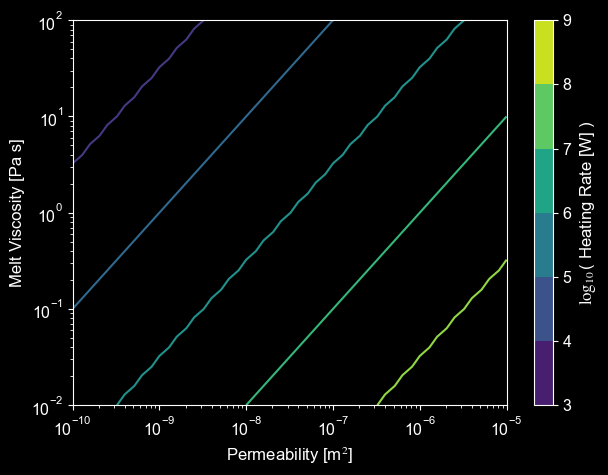

/home/hamish/anaconda3/lib/python3.9/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/hamish/anaconda3/lib/python3.9/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


In [10]:


c = ax.contourf(10.0 .^ks, 10.0 .^ηₗs, log10.(Edot'), levels=[3,4,5,6,7,8,9])
ax.contour(10.0 .^ks, 10.0 .^ηₗs, log10.(Edot') , levels=[3,4,5,6,7,8,9], colors="k")

M = 10.0 .^ks * (1.0 ./ (10.0 .^ηₗs))'
ax.contour(10.0 .^ks, 10.0 .^ηₗs, log10.(M'))
# ax.contour(ks, ηₗs, log10.(Edot'), colors="k")

cax = plt.colorbar(c, label="\$\\log_{10}\$( Heating Rate [W] )")

# ax.legend(frameon=false)

# ax.set_ylabel("Tidal Love Number \$|k_2|\$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Melt Viscosity [Pa s]")
ax.set_xlabel("Permeability [m\$^2\$]")

# fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)

ax.clear()
cax.remove()

### Incompressible

In [11]:
fig, ax = plt.subplots(ncols=1, figsize=(7,5))

(Figure(PyObject <Figure size 700x500 with 1 Axes>), PyObject <Axes: >)

In [12]:
κ = [100e9, 100e9, 1e20, 100e9] 
η = [1e30, 1e30, 1e30, 1e30]

ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 1e20, 0]
κd = 0.05κ
k = [0, 0, 1e-8, 0]

ηₗ = [0, 0, 1e-1, 0]

ks = -10:0.1:-5
ηₗs = -2:1:-2

M = -8:0.2:-4

Edot2 = zeros((length(M)))


for i in eachindex(M)
    # ηₗ[3] = 10.0^ηₗs[j] 
    k[3] = 10.0^M[i] * ηₗ[3] * (non_dim ? 1.0/R^2 : 1.0)

    # println(ηₗ)
    # println(k)

    μc = μ

    y = ComplexF64.(calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ,κd, ηₗ, ϕ, k))

    yR = y[:,end,end]

    k2 = yR[5] - 1

    Edot2[i] = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2

end


MethodError: MethodError: no method matching calculate_y(::Matrix{Double64}, ::Vector{Double64}, ::Matrix{Double64}, ::Vector{Complex{Double64}}, ::Vector{Float64}, ::Float64, ::Vector{Int64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Double64}, ::Vector{Float64})

Closest candidates are:
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:976
  ...


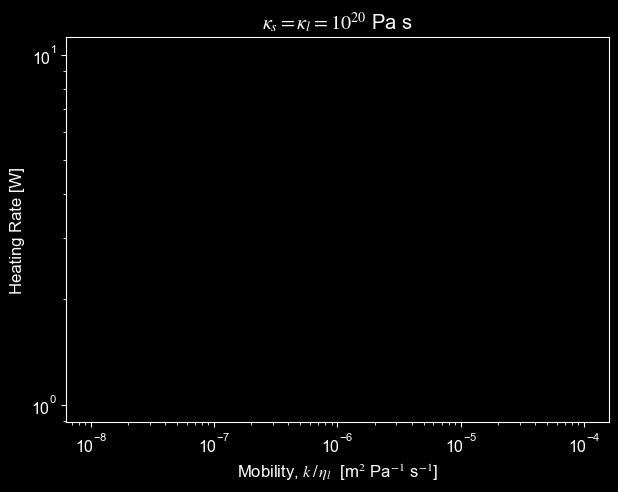

sys:1: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


In [13]:
ax.loglog(10. .^M, Edot2[:])

ax.set_ylabel("Heating Rate [W]")
ax.set_xlabel("Mobility, \$k\\, / \\, \\eta_l \$  [m\$^2\$ Pa\$^{-1}\$ s\$^{-1}\$]")

ax.set_title("\$\\kappa_s = \\kappa_l = 10^{$(Int64(log10(κ[3])))}\$ Pa s")


fig.savefig("mobility_heating_rate.png", dpi=500)

display(fig)

# ax.clear()


### Compressible

In [14]:
fig, ax = plt.subplots(ncols=1, figsize=(7,4))

(Figure(PyObject <Figure size 700x400 with 1 Axes>), PyObject <Axes: >)

In [15]:
κ = [100e9, 100e9, 100e9, 100e9] 
η = [1e30, 1e30, 1e30, 1e30]

ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 100e9, 0]  .* 10.0

k = [0, 0, 1e-8, 0]

ηₗ = [0, 0, 1e-1, 0]

ks = -10:0.1:-5
ηₗs = -2:1:-2

M = -8:0.2:-1

Ks = 10:1:13

Edot3 = zeros((length(M), length(Ks)))


for j in eachindex(Ks)
    κ[3] = 10.0^Ks[j]
    κₗ[3] = 10.0^Ks[j]
    κd = 0.05κ
    for i in eachindex(M)
        # ηₗ[3] = 10.0^ηₗs[j] 
        k[3] = 10.0^M[i] * ηₗ[3] * (non_dim ? 1.0/R^2 : 1.0)

        # println(ηₗ)
        # println(k)

        

        μc = μ

        y = ComplexF64.(calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ,κd, ηₗ, ϕ, k))

        yR = y[:,end,end]

        k2 = yR[5] - 1

        Edot3[i,j] = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2

    end
end

MethodError: MethodError: no method matching calculate_y(::Matrix{Double64}, ::Vector{Double64}, ::Matrix{Double64}, ::Vector{Complex{Double64}}, ::Vector{Float64}, ::Float64, ::Vector{Int64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Double64}, ::Vector{Float64})

Closest candidates are:
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:976
  ...


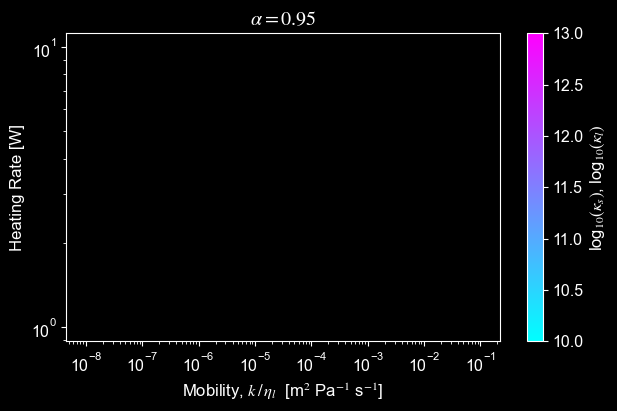

In [16]:
cmap = PyPlot.cm.cool

num = length(Ks)


for i in 1:num
    ax.loglog(10. .^M, Edot3[:,i], color=cmap(i/num))
end

ax.set_ylabel("Heating Rate [W]")
ax.set_xlabel("Mobility, \$k\\, / \\, \\eta_l \$  [m\$^2\$ Pa\$^{-1}\$ s\$^{-1}\$]")
ax.set_title("\$\\alpha = 0.95\$")

norm = mpl.colors.Normalize(vmax=Ks[end], vmin=Ks[1])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(sm, label="\$\\mathregular{log}_{10}\\left(\\kappa_s \\right)\$, \$\\mathregular{log}_{10}\\left(\\kappa_l \\right)\$")

fig.savefig("mobility_heating_rate.png", bbox_inches="tight", dpi=500)

display(fig)

ax.clear()
cb.remove()


In [17]:
fig, ax = plt.subplots(ncols=1, figsize=(7,5))

(Figure(PyObject <Figure size 700x500 with 1 Axes>), PyObject <Axes: >)

In [18]:
κ = [100e9, 100e9, 10e9, 100e9] 
η = [1e30, 1e30, 1e30, 1e30]

ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 10e9, 0] 
κd = 0.0κ
k = [0, 0, 1e-8, 0]

ηₗ = [0, 0, 1e-1, 0]

ϕ =  [0, 0, prec(0.1), 0]

ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
# ρ = ρₛ
# r = expand_layers(r)
g = get_g(r, ρ)


#incompressible 

# κₗ[3] = Inf64
# κ[3] = Inf64

ks = -10:0.1:-5
ηₗs = -2:1:2

Ks = 9:0.5:20
αs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
αs = -4:0.2:0

M = -8:0.5:-3

Edot2 = zeros((length(M), length(Ks)))
# Edot2 = zeros((length(M), length(αs)))

for j in eachindex(Ks)
# for j in eachindex(αs)
    # κd = κ*(1 - 10.0^αs[j])
    for i in eachindex(M)
        # ηₗ[3] = 10.0^ηₗs[ 
        k[3] = 10.0^M[i] * ηₗ[3] * (non_dim ? 1.0/R^2 : 1.0)

        κ[3] = 10.0 ^ Ks[j]
        κₗ[3] = 10.0 ^ Ks[j]

        κd = 0.05κ

        

        # κd .= 10.0 ^ Ks[j]



        μc = μ

        y = ComplexF64.(calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ,κd, ηₗ, ϕ, k))

        yR = y[:,end,end]

        k2 = yR[5] - 1

        Edot2[i,j] = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
    
    end
end

MethodError: MethodError: no method matching calculate_y(::Matrix{Double64}, ::Vector{Double64}, ::Matrix{Double64}, ::Vector{Complex{Double64}}, ::Vector{Float64}, ::Float64, ::Vector{Int64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Double64}, ::Vector{Float64})

Closest candidates are:
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:976
  ...


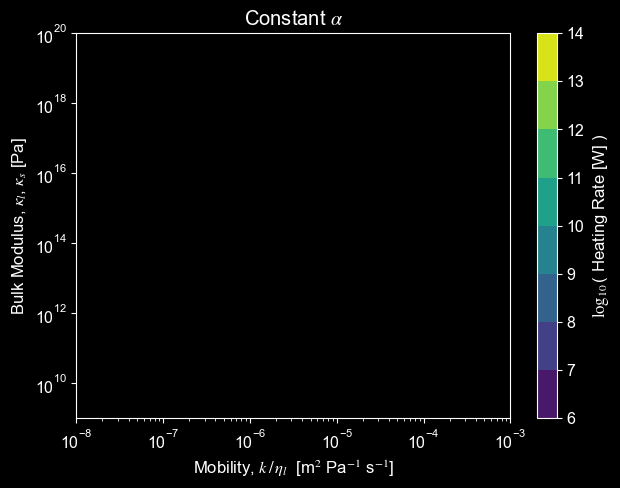

In [19]:
c = ax.contourf(10. .^M, 10. .^Ks, log10.(abs.(Edot2')), levels=6:1:14)
ax.contour(10. .^M, 10. .^Ks, log10.(abs.(Edot2')), levels=6:1:14, colors="k")

# c = ax.contourf(10. .^M, 10. .^ αs, log10.(abs.(Edot2')), levels=6:1:14)
# ax.contour(10. .^M, 10. .^ αs, log10.(abs.(Edot2')), levels=6:1:14, colors="k")

# ax.contourf(10. .^M, 10. .^Ks, log10.(abs.(Edot2')))

cax = plt.colorbar(c, label="\$\\log_{10}\$( Heating Rate [W] )")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Bulk Modulus, \$\\kappa_l\$, \$\\kappa_s\$ [Pa]")
# ax.set_ylabel("Biot's constant, \$\\alpha = (1 - \\kappa_d/\\kappa_s)\$")
ax.set_xlabel("Mobility, \$k\\, / \\, \\eta_l \$  [m\$^2\$ Pa\$^{-1}\$ s\$^{-1}\$]")
# ax.set_title("\$\\kappa_s = \\kappa_l = 10^{$(Int64(log10(κ[3])))}\$ Pa s")
ax.set_title("Constant \$\\alpha\$")

fig.savefig("mobility_vs_bulk_modulus_s=l.png", dpi=500)
# fig.savefig("mobility_vs_alpha_bulk_modulus_s=l_$(Int64(log10(κ[3]))).png", dpi=500)

display(fig)

ax.clear()
cax.remove()

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

(Figure(PyObject <Figure size 1200x400 with 2 Axes>), PyObject[PyObject <Axes: >, PyObject <Axes: >])

In [21]:
ϕs = -5.0:0.1:-1

-5.0:0.1:-1.0

In [22]:

ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 100e9, 0] 
κ = [0, 0, 100e9, 0] 
κd = 0.05κ
k = [0, 0, 1e-6, 0]

ηₗ = [0, 0, 1e0, 0]

η[3] = 1e18

ϕs = -5.0:0.1:-1


Es = zero(ϕs)
El = zero(ϕs)
Ek2 = zero(ϕs)
liquid_vel_max = zero(ϕs)
for j1 in eachindex(ϕs)
    ϕ[3] =  10.0 ^ ϕs[j1]

    ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
    g = get_g(r, ρ)

    μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

    y = ComplexF64.(calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, κd, ηₗ, ϕ, k))
    # y = calculate_y(r, ρ, g, μc, κ)

    yR = y[:,end,end]

    ###############################
    # Get total dissipation from k2:

    k2 = yR[5] - 1
    Ediss2 = 21.0/2.0 * -imag(k2) * (ω0*R)^5/G * e^2

    U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
    U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
    U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)

    sol_22  = get_solution(y, 2,   2, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, κd, ηₗ, ϕ, k, res)
    sol_20  = get_solution(y, 2,   0, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, κd, ηₗ, ϕ, k, res)



    ϵE = U22E*sol_22[2] + U20*sol_20[2] 
    ϵW = U22W*sol_22[2]

    ϵ = ϵE + conj.(ϵW)

    qE = U22E*sol_22[5] + U20*sol_20[5] 
    qW = U22W*sol_22[5]

    q = qE + conj.(qW)

    liquid_vel_max[j1] = maximum(abs.(-1im * ω * q + 1im * ω * conj.(q)))

    Eₛ_total = 0.0
    Eₗ_total = 0.0
    for j in 3:3
        for i in 1:size(r)[1]-1

            dr = (r[i+1, j] - r[i, j]) * (non_dim ? R : 1.0)

            Eₛ_vol = imag(μc[j]) * ω0 * (sum(abs.(ϵ[:,:,1:3,i,j]).^2, dims=3) .+ 2sum(abs.(ϵ[:,:,4:6,i,j]).^2, dims=3) .- (1/3)*abs.(sum(ϵ[:,:,1:3,i,j], dims=3)).^2 )     # Edot per unit volume
            
            if ϕ[j] > 0.0
                Eₗ_vol = 0.5 * ω^2 *ϕ[j]^2* ηₗ[j]/k[j] * (abs.(q[:,:,1,i,j]).^2 + abs.(q[:,:,2,i,j]).^2 + abs.(q[:,:,3,i,j]).^2)
                Eₗ_total += sum(sin.(clats) .* (Eₗ_vol * dr)  * dres^2 * r[i,j]^2.0)    # Integrate over volume
            end
            
            Eₛ_total += sum(sin.(clats) .* (Eₛ_vol * dr)  * dres^2 * r[i,j]^2.0)    # Integrate over volume
        end
    end

    Es[j1] = Eₛ_total;
    El[j1] = Eₗ_total;
    Ek2[j1] = Ediss2;

end






MethodError: MethodError: no method matching calculate_y(::Matrix{Double64}, ::Vector{Double64}, ::Matrix{Double64}, ::Vector{Complex{Double64}}, ::Vector{Float64}, ::Float64, ::Vector{Int64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Double64}, ::Vector{Float64})

Closest candidates are:
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:976
  ...


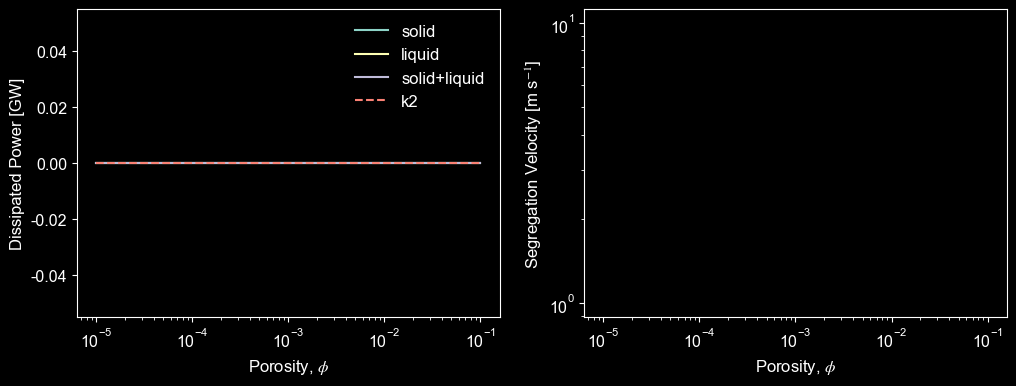

In [23]:
ax1.semilogx(10.0 .^ ϕs, Es/1e9, label="solid")
ax1.semilogx(10.0 .^ ϕs, El/1e9, label="liquid")
ax1.semilogx(10.0 .^ ϕs, (Es + El)/1e9, label="solid+liquid")
ax1.semilogx(10.0 .^ ϕs, Ek2/1e9, "--", label="k2")



ax1.legend(frameon=false)

ax1.set_xlabel("Porosity, \$\\phi\$")
ax1.set_ylabel("Dissipated Power [GW]")

ax2.set_xlabel("Porosity, \$\\phi\$")
ax2.set_ylabel("Segregation Velocity [m s\$^{-1}\$]")

ax2.loglog(10.0 .^ ϕs, liquid_vel_max)


fig.savefig("porosity_test_K23.png", bbox_inches="tight", dpi=500)
display(fig)

ax1.get_legend().remove()
ax1.clear()
ax2.clear()


In [24]:
fig, ax = plt.subplots()


ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 100e9, 0]
κ = [0, 0, 100e9, 0]
κd = 0.05κ
k = [0, 0, 1e-6, 0]

ηₗ = [0, 0, 1e0, 0]
ϕ = [0.0, 0.0, 0.1, 0.0]


η[3] = 1e8

# ϕs = 0.01:0.1:0.9

ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
g = get_g(r, ρ)

μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)
# μc = μ

y = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, κd, ηₗ, ϕ, k)
# y = calculate_y(r, ρ, g, μc, κ)

yR = y[:,end,end]

###############################
# Get total dissipation from k2:

k2 = yR[5] - 1
# k2_analy = 3/2 / (1 + 19/2 * μc[end] / (ρ[end]*R*g[end,end]))
# Ediss2 = 21.0/2.0 * -imag(k2) * (ω0*R)^5/G * e^2

#########################################
# Get total dissipation from strain field

U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
# function get_solution(y, n, m, r, ρ, g, μ, K, ω, ρₗ, Kl, Kd, ηₗ, ϕ, k, res=5.0)
sol_22  = get_solution(y, 2,   2, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, κd, ηₗ, ϕ, k, res)
# sol_22c  = get_solution(y, 2,   -2, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, κd, ηₗ, ϕ, k, res)
sol_20  = get_solution(y, 2,   0, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, κd, ηₗ, ϕ, k, res)

ϵE = U22E*sol_22[2] + U20*sol_20[2] 
ϵW = U22W*sol_22[2]

ϵ = ϵE + conj.(ϵW)

qE = U22E*sol_22[5] + U20*sol_20[5] 
qW = U22W*sol_22[5]

q = qE + conj.(qW)

dE = U22E*sol_22[1] + U20*sol_20[1] 
dW = U22W*sol_22[1]

d = dE + conj.(dW)


q = 0.5(q*exp(-1im * ω * 0.0) + conj.(q)*exp(1im * ω * 0.0))
d = 0.5(d*exp(-1im * ω * 0.0) + conj.(d)*exp(1im * ω * 0.0))
# ax.contourf(q[:,:,3,150,3], color="w")
c = ax.contourf(lons_deg .- 180.0, lats_deg, -d[:,:,1,end,4])

sk = 1
ax.quiver(lons_deg[1:sk:end] .- 180.0, lats_deg[1:sk:end], q[1:sk:end,1:sk:end,3,end,3], -q[1:sk:end,1:sk:end,2,end,3], color="w")


plt.colorbar(c, label="Radial Displacement [m]")

ax.set_title("Asthenospheric Darcy Flow, \$\\eta_s = 10^{8}\$ Pa s")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")

fig.savefig("Darcy_flow_highk2.png", dpi=500)

display(fig)


MethodError: MethodError: no method matching calculate_y(::Matrix{Double64}, ::Vector{Double64}, ::Matrix{Double64}, ::Vector{Complex{Double64}}, ::Vector{Float64}, ::Float64, ::Vector{Int64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64})

Closest candidates are:
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:907
  calculate_y(::Any, ::Any, ::Any, ::Any, ::Any, ::Any)
   @ Main.TidalLoveNumbers ~/Research/lovepy/TidalLoveNumbersPorousK23.jl:976
  ...


# Bulk dissipation

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))

(Figure(PyObject <Figure size 1000x400 with 2 Axes>), PyObject[PyObject <Axes: >, PyObject <Axes: >])

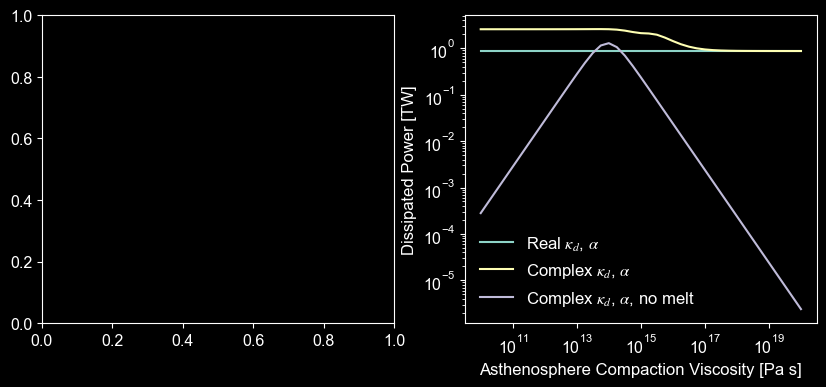

[2.806158388559634e8 4.9901335572674143e8 8.873851047342515e8 1.5780182607612355e9 2.80615513374741e9 4.990115254160044e9 8.873748122238787e9 1.5779603832028917e10 2.8058296906503407e10 4.9882856212268936e10 8.863467655365921e10 1.57219398947507e11 2.773662220375038e11 4.811858212533375e11 7.943225481600706e11 1.1514260045807432e12 1.2922155734936858e12 1.0606428682354052e12 6.97886132532912e11 4.147651836085098e11 2.375118972556151e11 1.3434108885339973e11 7.568503189515312e10 4.2585686741636246e10 2.39521167631328e10 1.3470052208212925e10 7.57490699315085e9 4.2597081304027147e9 2.3954143418011465e9 1.3470412625638661e9 7.574971086652067e8 4.259719528086304e8 2.3954163686315867e8 1.3470416229910988e8 7.574971727592574e7 4.259719642063246e7 2.395416388899897e7 1.3470416265953725e7 7.574971734002067e6 4.259719643203061e6 2.3954163891025656e6; 2.806158388559634e8 4.9901335572674143e8 8.873851047342515e8 1.5780182607612355e9 2.80615513374741e9 4.990115254160044e9 8.873748122238787e9 1.577

In [5]:
κ = [100e9, 100e9, 300e9 + 0im, 100e9] #* 1000e5
η = [1e30, 1e30, 1e20, 1e30]
η_solid = [1e30, 1e30, 1e20, 1e30]
μ = [60+0im, 60, 60, prec(60)] .* 1e9

ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 300e9, 0] #* 1000e5
κd = copy(κ)
κd[3] = 0.05 * κ[3]

# Set Biot's coefficient
α = zero(κd)
α[3] = κd[3]/κ[3]

# α = [0, 0, 0.0+0im, 0.0]
k = [0, 0, 1e-8, 0]

ηₗ = [0, 0, 1e-3, 0]

ϕ =  [0, 0, prec(0.1), 0]

ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk densityd

g = get_g(r, ρ)



ηs_shear = 19:1:20
ηs_bulk = 10:0.25:20
ks = -9:1:-6

Edot = zeros((length(ηs_shear), length(ηs_bulk)))
Edot_comp = zeros((length(ηs_shear), length(ηs_bulk)))
Edots = zeros((length(ηs_shear), length(ηs_bulk)))
k_ln = zeros(ComplexF64, (length(ηs_shear), length(ηs_bulk)))
k_lns = zeros(ComplexF64, (length(ηs_shear), length(ηs_bulk)))

# println(size(axes))

colors = ["C1", "C2", "C3", "C4"]
cmap = PyPlot.cm.cool
colors = [0.2, 0.4, 0.6, 0.8]
cnt = 0
for j in eachindex(ηs_bulk)
    for i in eachindex(ηs_shear)
        #######################################################################
        # η[3] = 10.0^ηs[i] * (non_dim ? 1.0/(μ0*T) : 1.0)
        
        κdc = copy(κd)
        κdc[3] = 1im * ω * κd[3] ./ (1im * ω .+ κd[3] ./ (10.0^ηs_bulk[j]))

        # println(κdc)

        αc = copy(α)
        αc[3] = (1im*ω*α[3] + κd[3]/(10.0^ηs_bulk[j])) / (1im*ω + κd[3]/(10.0^ηs_bulk[j]))

        μc = copy(μ)
        μc[3] =  1im*ω*μ[3] / (1im*ω .+ μ[3] / (10.0 .^ ηs_shear[i]))


        μc = μ

        y = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, κd, α, ηₗ, ϕ, k)
        yc = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, κdc, αc, ηₗ, ϕ, k)

        
        κsc = copy(κ)
        κsc[3] = 1im * ω * κ[3] / (1im*ω + μ[3] / (10.0 ^ ηs_bulk[j])) 

        y2 = calculate_y(r, ρ, g, μc, κsc)

        yR = y[end,end]
        yRc = yc[end,end]
        yR2 = y2[end,end]

        k2 = yR[5] - 1
        k2c = yRc[5] - 1
        k22 = yR2[5] - 1

        k_ln[i,j] = k2
        k_lns[i,j] = k22
    
        Edot[i,j] = 21/2 * imag(k2) * (ω0*R)^5/G * e^2
        Edot_comp[i,j] = 21/2 * imag(k2c) * (ω0*R)^5/G * e^2
        Edots[i,j] = 21/2 * -imag(k22) * (ω0*R)^5/G * e^2

       

    end
    cnt += 1
end


println(Edots)

# c = axes[2].contourf(10.0 .^ collect(ηs_shear), 10.0 .^ collect(ηs_bulk), Edot' ./ 1e12)
# cbar = plt.colorbar(c)
# # end
# axes[2].loglog(10.0 .^ collect(ηs_shear), abs.(Edot[:,:1])/1e12, lw=3.0, label="Two-phase")
# axes[2].loglog(10.0 .^ collect(ηs_bulk), abs.(Edots[1,:])/1e12, lw=3.0)

levels=[-4,-3, -2, -1, 0, 1, 2, 3, 4]

# c1 = axes[1].contourf(10.0 .^ collect(ηs_shear), 10.0 .^ collect(ηs_bulk), log10.(abs.(Edots')/1e12), levels=levels)
# axes[1].contour(10.0 .^ collect(ηs_shear), 10.0 .^ collect(ηs_bulk), log10.(abs.(Edots')/1e12), levels=[2], colors="k")

# axes[1].set_xscale("log")
# axes[1].set_yscale("log")


# c2 = axes[2].contourf(10.0 .^ collect(ηs_shear), 10.0 .^ collect(ηs_bulk), log10.(abs.(Edot')/1e12), levels=levels)
# axes[2].contour(10.0 .^ collect(ηs_shear), 10.0 .^ collect(ηs_bulk), log10.(abs.(Edot')/1e12), levels=[2], colors="k")

axes[2].loglog(10.0 .^ collect(ηs_bulk), abs.(Edot[1,:])/1e12, label="Real \$\\kappa_d\$, \$\\alpha\$")
axes[2].loglog(10.0 .^ collect(ηs_bulk), abs.(Edot_comp[1,:])/1e12, label="Complex \$\\kappa_d\$, \$\\alpha\$")
axes[2].loglog(10.0 .^ collect(ηs_bulk), abs.(Edots[1,:])/1e12, label="Complex \$\\kappa_d\$, \$\\alpha\$, no melt")
# axes[2].contour(10.0 .^ collect(ηs_shear), 10.0 .^ collect(ηs_bulk), log10.(abs.(Edot')/1e12), levels=[2], colors="k")


axes[2].set_xscale("log")
axes[2].set_yscale("log")

# cbar1 = plt.colorbar(c1)
# cbar2 = plt.colorbar(c2)

axes[2].legend(frameon=false)

# axes[1].set_ylabel("Tidal Love Number \$|k_2|\$")
axes[2].set_ylabel("Dissipated Power [TW]")
# axes[1].set_xlabel("Asthenosphere Viscosity [Pa s]")
axes[2].set_xlabel("Asthenosphere Compaction Viscosity [Pa s]")

# axes[2].axhspan((9.33-1.87)*1e13/1e12, (9.33+1.87)*1e13/1e12, alpha=0.8)
# axes[1].set_ylim([0,1.3])
fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)
axes[1].clear()
axes[2].clear()
# cbar2.remove()
# cbar1.remove()

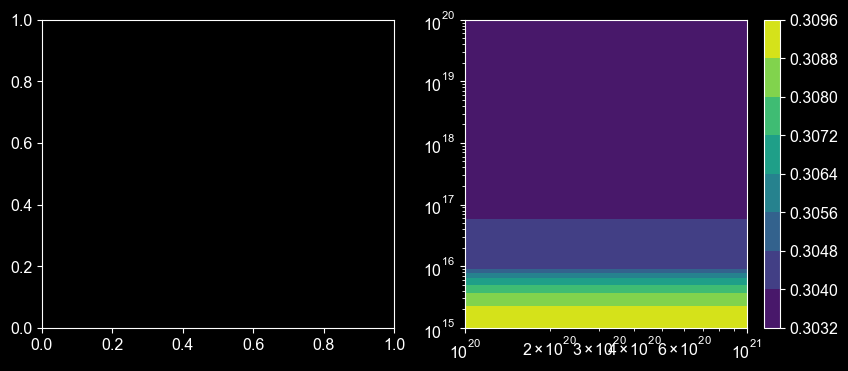

In [29]:
# for j in eachindex(ks)
    # axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_ln), label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(cnt/length(ks)), lw=3.0)
    # axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_lns), "w--")

c = axes[2].contourf(10.0 .^ collect(ηs_shear), 10.0 .^ collect(ηs_bulk), Edot' ./ 1e12)
cbar = plt.colorbar(c)
# end
# axes[2].loglog(10.0 .^ collect(ηs), Edots[:]/1e12, "w--", lw=3.0)

axes[2].set_xscale("log")
axes[2].set_yscale("log")

# axes[2].legend(frameon=false)

# axes[1].set_ylabel("Tidal Love Number \$|k_2|\$")
# axes[2].set_ylabel("Dissipated Power [TW]")
# axes[1].set_xlabel("Asthenosphere Viscosity [Pa s]")
# axes[2].set_xlabel("Asthenosphere Viscosity [Pa s]")

# axes[2].axhspan((9.33-1.87)*1e13/1e12, (9.33+1.87)*1e13/1e12, alpha=0.8)
# axes[1].set_ylim([0,1.3])
# fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)
axes[1].clear()
axes[2].clear()
cbar.remove()

In [30]:

for j in eachindex(ks)
    # axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_ln), label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(cnt/length(ks)), lw=3.0)
    # axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_lns), "w--")

    axes[2].loglog(10.0 .^ collect(ηs), Edot[:,j]/1e12, label="k=10\$^{$(ks[j])}\$ m\$^{2}\$", color=cmap((j-1)/length(ks)), lw=3.0)
end
axes[2].loglog(10.0 .^ collect(ηs), Edots[:]/1e12, "w--", lw=3.0)


axes[2].legend(frameon=false)

axes[1].set_ylabel("Tidal Love Number \$|k_2|\$")
axes[2].set_ylabel("Dissipated Power [TW]")
axes[1].set_xlabel("Asthenosphere Viscosity [Pa s]")
axes[2].set_xlabel("Asthenosphere Viscosity [Pa s]")

axes[2].axhspan((9.33-1.87)*1e13/1e12, (9.33+1.87)*1e13/1e12, alpha=0.8)
axes[1].set_ylim([0,1.3])
# fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)
axes[1].clear()
axes[2].clear()

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/hamish/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (29,) and (2,)')
  File "/home/hamish/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 1829, in loglog
    return self.plot(
  File "/home/hamish/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/hamish/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/home/hamish/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "


In [31]:

for j in eachindex(ks)
    # axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_ln), label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(cnt/length(ks)), lw=3.0)
    # axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_lns), "w--")

    axes[2].loglog(10.0 .^ collect(ηs), Edot[:,j]/1e12, label="k=10\$^{$(ks[j])}\$ m\$^{2}\$", color=cmap((j-1)/length(ks)), lw=3.0)
end


axes[2].legend(frameon=false)

axes[1].set_ylabel("Tidal Love Number \$|k_2|\$")
axes[2].set_ylabel("Dissipated Power [TW]")
axes[1].set_xlabel("Asthenosphere Viscosity [Pa s]")
axes[2].set_xlabel("Asthenosphere Viscosity [Pa s]")

axes[2].axhspan((9.33-1.87)*1e13/1e12, (9.33+1.87)*1e13/1e12, alpha=0.8)
axes[1].set_ylim([0,1.3])
# fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)
axes[1].clear()
axes[2].clear()

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/hamish/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (29,) and (2,)')
  File "/home/hamish/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 1829, in loglog
    return self.plot(
  File "/home/hamish/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/hamish/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/home/hamish/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "
